### Naive Bayes
***
##### Al tener datos numéricos y categóricas se entrenarán modelos de Naive Bayes Gaussianos y Categóricos para cada grupo de festures y luego se combinarán sus probabilidades en un modelo final.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix ,classification_report

***
##### Preparación de los datos

In [2]:
data = pd.read_csv('../data/data_to_model.csv')

In [3]:
data.columns

Index(['gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco',
       'active', 'cardio', 'AgeinYr', 'TAS', 'TAD', 'PP', 'bmi', 'fram',
       'esc'],
      dtype='object')

In [4]:
# Separo x de y
y = data.cardio
x = data.drop(columns=['cardio','fram','esc','height', 'weight'])

In [5]:
# Genero dummies en X
x_dummy = pd.get_dummies(x, drop_first=True)

In [7]:
# Separo en train y test
# Se realiza la estratificación en x_train y x_test con gender, ya que es una variable de alto impacto y se encuenyra desbalanceada
X_train, X_test, y_train, y_test = train_test_split(x_dummy, y, random_state=34, stratify=x_dummy.gender_m, shuffle=True)


***
##### Entrenamiento del modelo

##### Detalle:
- Se separan las features en categoricas y numericas
- Lluego se entrenan modelos de naive bayes categoricos y gaussianos respectivamente
- Se realiza un predicción de probabilidades (predict_proba) para cada categoría (1 o 0) por sobre cada uno de los modelos en los datos de train y de test por separado obtieniendode matrices con las probabilidades de cada categoria
- Luego se extrae la columna de probabilidades que corresponde a la categoria 1 y se combinan (np.c_) en una nueva matriz
- Se conforma así una matriz (nro_elementos,2), con la probabilidad de tener la clase 1 en el subconjunto de features categoricas y numéricas
- Se entrena un modelo Gaussiano con esta matriz, sobre el cual vamos a obtener las predicciones finales (predict).

In [8]:
# Se separan las columnas que corresponden a features categóricos de los numéricos
categorical_cols=['gender_m', 'cholesterol_limitrofe', 'cholesterol_normal',\
    'gluc_normal', 'gluc_prediabetes', 'smoke_si', 'alco_si', 'active_si']

numerical_cols = ['AgeinYr', 'TAS', 'TAD', 'PP', 'bmi']

In [9]:
# Instancio y entreno
gaussNB=GaussianNB()  # Numericas
gaussNB.fit(X_train[numerical_cols],y_train)
categNB=MultinomialNB()  # Categoricas
categNB.fit(X_train[categorical_cols],y_train)

# Hago predict proba sobre cada X train y test numerico y categorico
G_train_probas= gaussNB.predict_proba(X_train[numerical_cols])
C_train_probas = categNB.predict_proba(X_train[categorical_cols])

G_test_probas= gaussNB.predict_proba(X_test[numerical_cols])
C_test_probas = categNB.predict_proba(X_test[categorical_cols])

# Combino las probabilidades para la clase 1 en un array 2D
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1])] # Test

# Instancio y entreno un NB Gaussiano para X_new
finalNB=GaussianNB()
finalNB.fit(X_new_train, y_train)

# Hago un predict sobre train
y_pred_naive_train = finalNB.predict(X_new_train)

# Hago un predict sobre test
y_pred_naive_test = finalNB.predict(X_new_test)


*** 
##### Evaluación de los resultados

In [10]:
print(f'Predicciones sobre train \n {classification_report(y_train,y_pred_naive_train)}')

Predicciones sobre train 
               precision    recall  f1-score   support

           0       0.67      0.81      0.74     25264
           1       0.76      0.60      0.67     25250

    accuracy                           0.71     50514
   macro avg       0.72      0.71      0.70     50514
weighted avg       0.72      0.71      0.70     50514



In [11]:
print(f'Predicciones sobre test \n {classification_report(y_test,y_pred_naive_test)}')

Predicciones sobre test 
               precision    recall  f1-score   support

           0       0.67      0.81      0.74      8531
           1       0.76      0.60      0.67      8308

    accuracy                           0.71     16839
   macro avg       0.71      0.70      0.70     16839
weighted avg       0.71      0.71      0.70     16839



##### El modelo no tiene overfitting

##### Se valoran diferentes puntos de corte para clasificar la variable target

In [12]:
def tunning_probs(probas,thr):
    """
        Recibe la matriz de probabilidades para las categorias 0 y 1 y el threshold elegido
        Devielve el vector de probabilidades binarizado acorde al threshold
    """
    #Hacemos un predict_proba en y_pred_proba y lo modificamos con binarize a 0 o 1 según el threshold elegido
    from sklearn.preprocessing import binarize
    return binarize(probas, threshold=thr)[:,1]

In [13]:
def explore_threshold(y_true, probas, ranges):
    """
        Recibe la matriz de probabilidades de cada categoria y el rango de threshold, evalua"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    import matplotlib.pyplot as plt
    acc=list(); precis=list(); rec = list()
    for thr in ranges:
        predictions = tunning_probs(probas,thr)
        acc.append(accuracy_score(y_true, predictions))
        precis.append(precision_score(y_true, predictions))
        rec.append(recall_score(y_true, predictions))
    plt.plot(ranges,acc)
    plt.plot(ranges, precis)
    plt.plot(ranges, rec)
    plt.legend(['Accuracy', 'Precission', 'Recall'])
    plt.xlabel('Threshold')
    plt.show()

In [14]:
probas = finalNB.predict_proba(X_new_test)


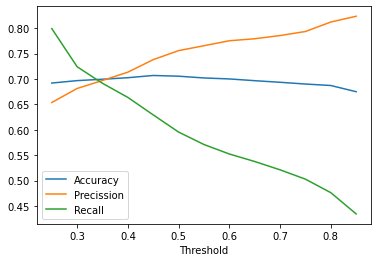

In [15]:
explore_threshold(y_test, probas, [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85])

In [17]:
print('Se elige un threshold de 0.33 ya que se obtiene un valor balanceado de Recall y Precision')
print(classification_report(y_test, tunning_probs(probas,0.33)))

Se elige un threshold de 0.33 ya que se obtiene un valor balanceado de Recall y Precision
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      8531
           1       0.69      0.70      0.70      8308

    accuracy                           0.70     16839
   macro avg       0.70      0.70      0.70     16839
weighted avg       0.70      0.70      0.70     16839

